# HYSETS Visualization Notebook
This notebook demonstrates visualization capabilities for the HYSETS dataset, focusing on Credit River basins (CVC).

## Import libraries and setup
Load required libraries for data handling, plotting, and NeuralHydrology utilities.

In [1]:
from pathlib import Path
import sys
import numpy as np
import os
import pandas as pd
import numpy as np
sys.path.append("../..")
from neuralhydrology.datasetzoo.hysets import load_hysets_attributes, load_hysets_timeseries, load_hysets_boundaries

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config


# Example: Load and analyze multiple runs
from neuralhydrology.utils.run_analysis import load_runs_to_dataframe, compare_runs, find_varying_configs, summarize_runs


data_dir = Path("F:\Data\LSH\HYSETS_2023")
cvc_basins = ['02HB029', '02HB031']



## Load and examine time series data
Load time series data for a specific Credit River basin and display the first few rows.

In [36]:
ts = load_hysets_timeseries(data_dir, basin=cvc_basins[1])
ts.head()

,discharge,2m_dewpoint,2m_tasmax,2m_tasmin,10m_u_component_of_wind,10m_v_component_of_wind,evaporation,total_runoff,snow_density,snow_water_equivalent,...,snowfall,snowmelt,surface_net_solar_radiation,surface_net_thermal_radiation,surface_pressure,surface_runoff,surface_downwards_solar_radiation,surface_downwards_thermal_radiation,total_cloud_cover,total_precipitation
date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot discharge and precipitation time series
Create a dual-axis plot showing discharge and precipitation data over time for the selected basin.

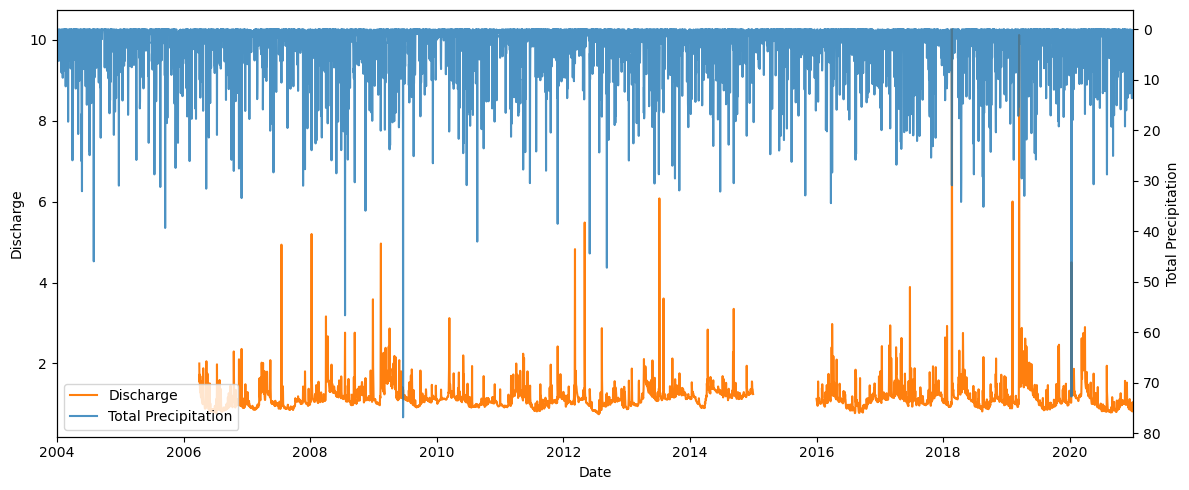

In [42]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts.index, ts["discharge"], label="Discharge", color="tab:orange")
ax.set_ylabel("Discharge")
ax.set_xlabel("Date")
ax.set_xlim(pd.to_datetime("2004-01-01"), pd.to_datetime("2020-12-31"))

ax2 = ax.twinx()
ax2.plot(ts.index, ts["total_precipitation"], label="Total Precipitation", color="tab:blue", alpha=0.8)
ax2.set_ylabel("Total Precipitation")
ax2.invert_yaxis()

# combined legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="lower left")


fig.tight_layout()
plt.show()

## Display basin attributes
Load and display the attributes for the Credit River basins.

In [9]:
attributes = load_hysets_attributes(data_dir)
attributes.loc[cvc_basins]

,Drainage_Area_km2,Drainage_Area_GSIM_km2,Elevation_m,Slope_deg,Gravelius,Perimeter,Aspect_deg,Land_Use_Forest_frac,Land_Use_Grass_frac,Land_Use_Wetland_frac,...,low_q_dur,zero_q_freq,fdc_slope,q95,q5,runoff_ratio,pet_mean,aridity,frac_snow,temp_mean
02HB029,774.2404,NaN,357.7,1.5991,2.3784,235.828,110.6498,0.2897,0.0366,0.0058,...,0.0,0.0,1.484473,2.609608,0.319157,0.042871,-0.050075,-0.000644,0.297841,12.548585
02HB031,12.4605,NaN,468.6,2.0021,1.6602,20.885,110.8427,0.1784,0.0355,0.0020,...,0.0,0.0,0.528344,2.100975,0.839003,3.102980,-0.050793,-0.000622,0.320481,11.915212


## Visualize basin boundaries with urban land use
Create a map of Southern Ontario showing basin boundaries colored by urban land use fraction, with a contextual basemap.

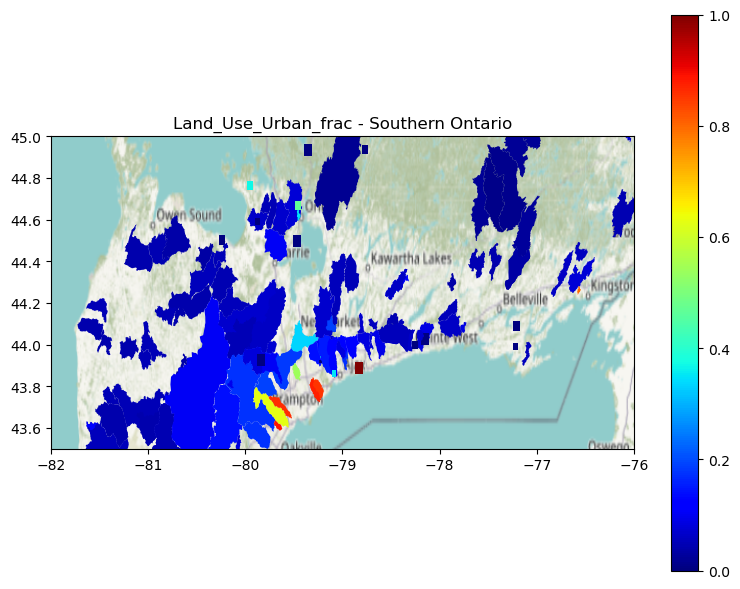

In [10]:
import contextily as ctx

boundaries = load_hysets_boundaries(data_dir)

fig, ax = plt.subplots(figsize=(8, 6))
boundaries.plot(column="Land_Use_Urban_frac", cmap="jet", legend=True, ax=ax)
ax.set_xlim(-82, -76)
ax.set_ylim(43.5, 45)
ax.set_title("Land_Use_Urban_frac - Southern Ontario")

# add basemap
ctx.add_basemap(ax, crs=boundaries.crs.to_string())

# remove map credit/attribution text added by contextily
for txt in list(ax.texts):
    txt_val = txt.get_text()
    if "©" in txt_val or "OpenStreetMap" in txt_val or "Map" in txt_val or "Attribution" in txt_val:
        txt.remove()

plt.tight_layout()
plt.show()

## Load model results and create comparison plots
Load results from a trained model and create subplot comparisons of observed vs. simulated discharge for Credit River basins.

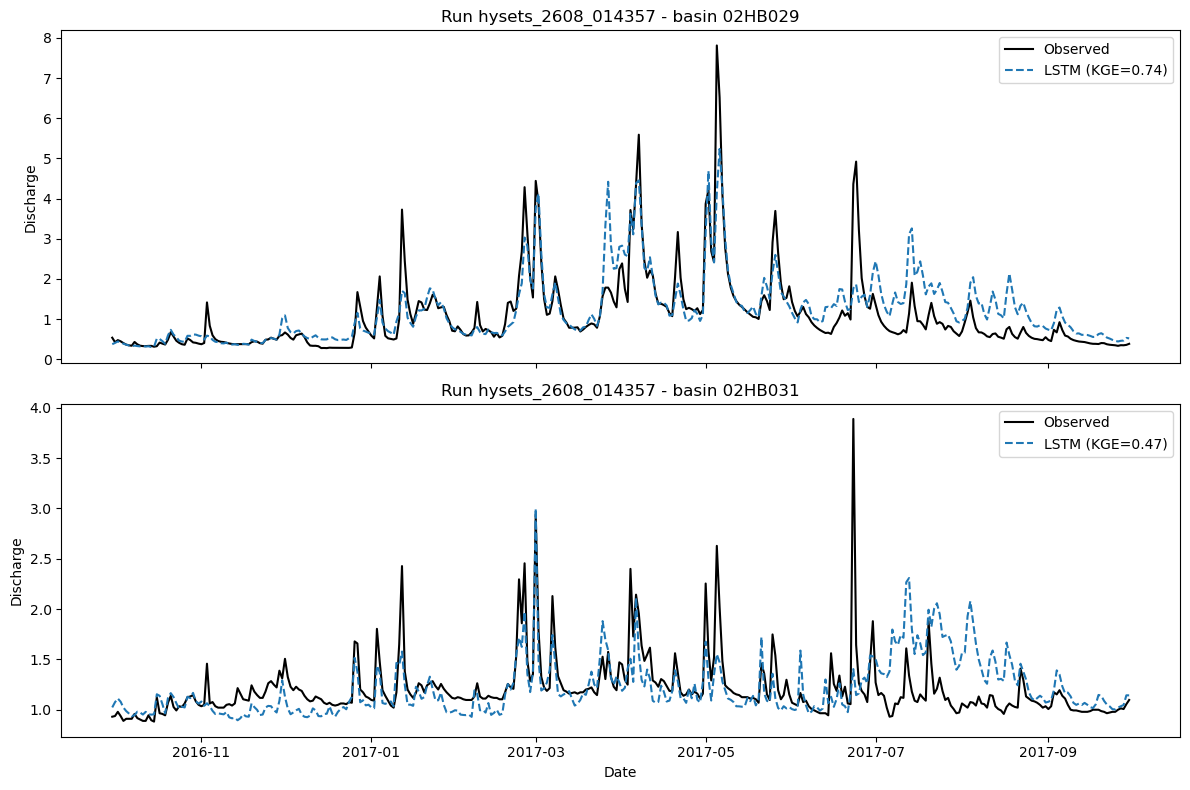

In [ ]:
from neuralhydrology.utils.run_analysis import load_results

run_dir1 = Path("runs") / "hysets_2608_014357"
results1 = load_results(run_dir1, epoch=-1, split="test")

def plot_cvc_subplots(results, basins, date_range=None, start_day=0, n_days=365):
    n = len(basins)
    fig, axs = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)
    if n == 1:
        axs = [axs]
    for ax, basin in zip(axs, basins):
        if basin not in results:
            ax.text(0.5, 0.5, f"Missing basin {basin}", ha='center', va='center')
            ax.set_ylabel('Discharge')
            continue

        dat = results[basin]['1D']["xr"]
        discharge_obs = dat['discharge_obs'].squeeze()
        discharge_sim = dat['discharge_sim'].squeeze()
        dates = dat['date'].values

        if date_range is None:
            date_range = [dates[0] + np.timedelta64(start_day, 'D'), dates[0] + np.timedelta64(start_day + n_days, 'D')]
            # period

        if date_range is not None:
            start, end = [np.datetime64(d) for d in date_range]
            mask = (dates >= start) & (dates <= end)
            discharge_obs = discharge_obs[mask]
            discharge_sim = discharge_sim[mask]
            dates = dates[mask]

        kge = metrics.kge(discharge_sim, discharge_obs)

        ax.plot(dates, discharge_obs, label='Observed', color='black')
        ax.plot(dates, discharge_sim, label=f'LSTM (KGE={kge:.2f})', linestyle='--')
        ax.set_ylabel('Discharge')
        ax.set_title(f'Run {run_dir1.name} - basin {basin}')
        ax.legend()

    axs[-1].set_xlabel('Date')
    fig.tight_layout()
    plt.show()

plot_cvc_subplots(results1, cvc_basins, start_day=365*2, n_days=365)

